### Práctica: Sintonización y Simulación de un Controlador PID por Ziegler-Nichols.

**Objetivo:**
Utilizar el modelo de Función de Transferencia (FT) FOPDT (Primer Orden más Tiempo Muerto) obtenido en la práctica anterior. Calcular las ganancias iniciales de un controlador PID utilizando las reglas de sintonización de Ziegler-Nichols (método de lazo abierto). Simular la respuesta del sistema en lazo cerrado, analizarla y realizar una sintonización fina para mejorar su desempeño.

---

### Paso 1: El modelo del sistema de temperatura LTR701.

En la práctica anterior, identificamos el comportamiento del sistema de temepratura LTR701 y lo modelamos con una función de transferencia FOPDT:

$$G_p(s) = \frac{K \cdot e^{-Ls}}{Ts + 1}$$

Esta FT relaciona la **entrada de voltaje al calefactor** ($V_{pwm}$) con la **salida de voltaje del sensor** ($V_{sensor}$).

**Introduzca sus valores calculados de la práctica anterior en la siguiente celda de código.**

In [56]:
# Importar las bibliotecas necesarias
import control as ct
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Parámetros del sistema de temperatura LTR701 (Obtenidos en la práctica anterior) ---
# (REEMPLACE CON SUS VALORES)
K = 1.000
L = 7.002
T = 8.615

# --- 2. Creación del Modelo de la Planta Gp(s) ---

# La simulación en Python no maneja el retardo e^{-Ls} de forma nativa en tf.
# Usamos una "Aproximación de Padé" de primer orden, que es un estándar
# para simular el retardo de tiempo.
pade_delay = ct.tf(*ct.pade(L, n=1)) # n=1 es el orden de la aproximación

# Creamos la FT de la planta (sin el retardo)
Gp_no_delay = ct.tf([K], [T, 1])

# Multiplicamos para obtener la planta completa
Gp = Gp_no_delay * pade_delay

print("Función de Transferencia de la Planta (con aproximación de Padé):")
print(Gp)

Función de Transferencia de la Planta (con aproximación de Padé):
<TransferFunction>: sys[341]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

          -s + 0.2856
  ----------------------------
  8.615 s^2 + 3.461 s + 0.2856


### Paso 2: Definición del Setpoint (Referencia)

Antes de sintonizar, definamos nuestro objetivo. Queremos que el sistema alcance y mantenga una temperatura de **35 °C**.

Nuestra hoja de datos indica que **10°C = 1V**. Además, nuestro modelo se obtuvo haciendo un escalón desde un estado base (ej. 20% PWM), no desde 0. Asumamos que la temperatura ambiente (nuestra línea base) es de **25 °C**.

* **Temperatura Deseada (Setpoint):** $T_{setpoint} = 35^\circ C$
* **Temperatura Inicial (Línea Base):** $T_{inicial} = 25^\circ C$

Ahora, convertimos esto a Voltios para nuestra simulación, ya que nuestro modelo $G_p(s)$ (y por lo tanto nuestro controlador) trabaja con Voltios.

* **Voltaje de Referencia (Setpoint):** $V_{ref} = 35^\circ C \times (1V / 10^\circ C) = 3.5 V$
* **Voltaje Inicial (Línea Base):** $V_{base} = 25^\circ C \times (1V / 10^\circ C) = 2.5 V$

In [57]:
# --- 2. Definición de Setpoint y Voltajes de Operación ---
V_ref = 3.2    # Voltaje objetivo (corresponde a 35°C)
V_base = 2.4   # Voltaje inicial (corresponde a 25°C)

# El tamaño del escalón que simulamos es la diferencia
step_size = V_ref - V_base

print(f"Voltaje de Referencia (Setpoint): {V_ref:.2f} V")
print(f"Voltaje Inicial (Línea Base): {V_base:.2f} V")
print(f"Tamaño del Escalón a simular: {step_size:.2f} V")

Voltaje de Referencia (Setpoint): 3.20 V
Voltaje Inicial (Línea Base): 2.40 V
Tamaño del Escalón a simular: 0.80 V


### Paso 3: Reglas de Sintonización de Ziegler-Nichols (Lazo Abierto)

Ziegler y Nichols propusieron una tabla de sintonización empírica basada en los parámetros $K$, $L$ y $T$ de la curva S.

**Tabla de Sintonización de Ziegler-Nichols (Método 1):**

| Tipo de Controlador | $K_p$ | $T_i$ | $T_d$ |
| :--- | :--- | :--- | :--- |
| P | $T / (K \cdot L)$ | $\infty$ | $0$ |
| PI | $0.9 \cdot T / (K \cdot L)$ | $L / 0.3$ | $0$ |
| **PID** | **$1.2 \cdot T / (K \cdot L)$** | **$2L$** | **$0.5L$** |

Usaremos las fórmulas de la fila **PID**. Las conversiones de $T_i$ y $T_d$ a las ganancias $K_i$ y $K_d$ son:

* $K_i = K_p / T_i$
* $K_d = K_p \cdot T_d$

In [58]:
# --- 3. Cálculo de Ganancias PID "Raw" (Ziegler-Nichols) ---

# Aplicamos las fórmulas de la tabla para un PID
Kp_zn = (1.2 * T) / (K * L)
Ti_zn = 2 * L
Td_zn = 0.5 * L

# Convertimos a las ganancias Kp, Ki, Kd
Ki_zn = Kp_zn / Ti_zn
Kd_zn = Kp_zn * Td_zn

print("--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_zn:.4f}")
print(f"Ki = {Ki_zn:.4f}")
print(f"Kd = {Kd_zn:.4f}")

--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = 1.4764
Ki = 0.1054
Kd = 5.1690


### Paso 4: Simulación del Controlador PID "Raw"

Ahora crearemos la función de transferencia del controlador PID.
$$G_c(s) = \frac{K_d s^2 + K_p s + K_i}{s}$$

Simularemos la respuesta del sistema en lazo cerrado ante un escalón que va desde nuestro voltaje base ($V_{base}$) hasta nuestro voltaje de referencia ($V_{ref}$).

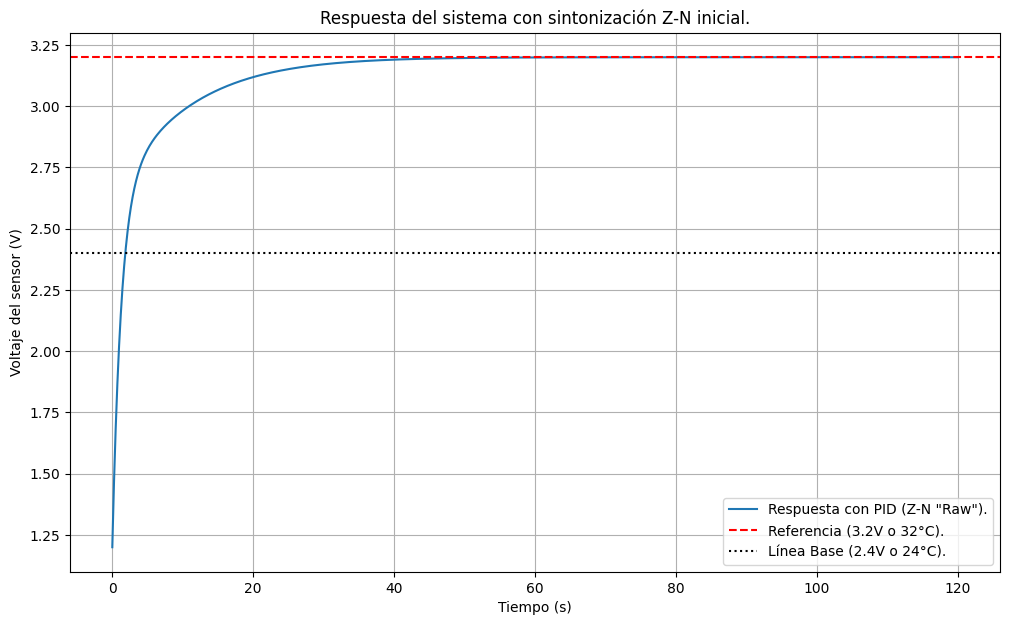


Información de la respuesta (escalón unitario):
  - Sobreimpulso (Overshoot): 0.00%
  - Tiempo de Establecimiento (SettlingTime): 35.71 s


In [59]:
# --- 4. Creación del Controlador PID y Simulación ---

# FT del controlador PID (Numerador=[Kd, Kp, Ki], Denominador=[1, 0])
Gc_zn = ct.tf([Kd_zn, Kp_zn, Ki_zn], [1, 0])

# Sistema en Lazo Cerrado
sistema_cl_zn = ct.feedback(Gc_zn * Gp, 1)

# Simulación de la respuesta al escalón.
# ct.step_response calcula la respuesta a un escalón de magnitud 1.
t_sim, y_unit_step = ct.step_response(sistema_cl_zn, T=np.linspace(0, 120, 1000))

# --- Escalamos la respuesta ---
# La respuesta real es el cambio (y_unit_step * step_size) sumado al valor inicial (V_base)
y_zn = (y_unit_step * step_size) + V_base

# --- Graficación ---
plt.figure(figsize=(12, 7))
plt.plot(t_sim, y_zn, label='Respuesta con PID (Z-N "Raw").')

# La referencia (setpoint) ahora es V_ref
plt.axhline(y=V_ref, color='r', linestyle='--', label=f'Referencia ({V_ref:.1f}V o {V_ref*10:.0f}°C).')
plt.axhline(y=V_base, color='k', linestyle=':', label=f'Línea Base ({V_base:.1f}V o {V_base*10:.0f}°C).')
plt.title('Respuesta del sistema con sintonización Z-N inicial.')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje del sensor (V)')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir información de la respuesta
# ct.step_info es para un escalón unitario, por lo que lo usamos con y_unit_step
info = ct.step_info(sistema_cl_zn) 
print("\nInformación de la respuesta (escalón unitario):")
print(f"  - Sobreimpulso (Overshoot): {info['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info['SettlingTime']:.2f} s")

### Paso 5: Sintonización Fina (Fine-Tuning).

Observe la gráfica anterior. La sintonización de Ziegler-Nichols es conocida por ser **agresiva**, resultando en un **alto sobreimpulso** y oscilaciones. El sistema es estable, pero su desempeño no es óptimo.

Nuestro trabajo ahora es realizar la **sintonización fina** para mejorar la respuesta. Usaremos las siguientes reglas generales:

* **Para reducir el sobreimpulso:** Disminuir $K_p$ y/o Aumentar $K_d$.
* **Para eliminar el error estacionario más rápido:** Aumentar $K_i$ (pero con cuidado, demasiado $K_i$ causa oscilación).
* **Para una respuesta más rápida (general):** Aumentar $K_p$.

**Instrucción:** Copie las ganancias "Raw" en la celda siguiente y ajústelas manualmente. Su objetivo es encontrar un balance que cumpla con los requisitos del ejercicio propuesto.

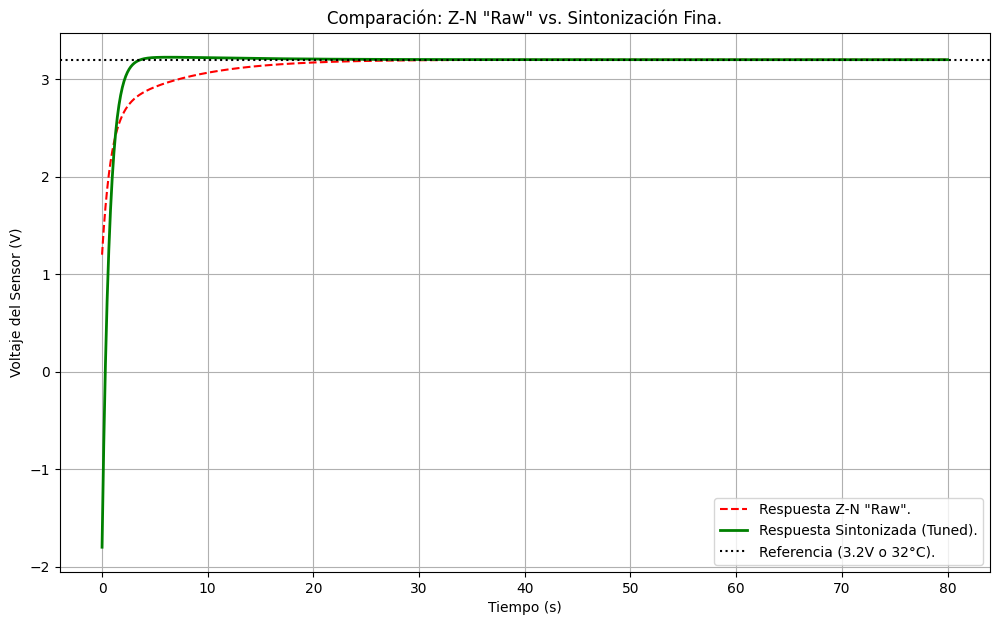


Información de la respuesta (Sintonizada, escalón unitario):
  - Sobreimpulso (Overshoot): 2.57%
  - Tiempo de Establecimiento (SettlingTime): nan s
--- Ganancias Iniciales (Ziegler-Nichols) ---
Kp = 2.9529
Ki = 0.2636
Kd = 7.2366


In [60]:
# --- 5. Espacio de Trabajo para Sintonización Fina ---

# MODIFIQUE ESTOS VALORES PARA ENCONTRAR UNA MEJOR RESPUESTA:
Kp_tuned = Kp_zn * 2.0  # Ejemplo: Reducir Kp
Ki_tuned = Ki_zn * 2.5  # Ejemplo: Reducir Ki
Kd_tuned = Kd_zn * 1.4  # Ejemplo: Aumentar Kd

# --- Creación del controlador PID Sintonizado ---
Gc_tuned = ct.tf([Kd_tuned, Kp_tuned, Ki_tuned], [1, 0])

# --- Sistema en Lazo Cerrado Sintonizado ---
sistema_cl_tuned = ct.feedback(Gc_tuned * Gp, 1)

# --- Simulación ---
# Obtenemos la respuesta al escalón unitario
t_sim, y_unit_step_tuned = ct.step_response(sistema_cl_tuned, T=np.linspace(0, 80, 1000))

# --- Escalamos la respuesta ---
y_tuned = (y_unit_step_tuned * step_size) + V_base
# y_zn (del cálculo anterior) ya está escalada

# --- Graficación Comparativa ---
plt.figure(figsize=(12, 7))
plt.plot(t_sim, y_zn, 'r--', label='Respuesta Z-N "Raw".')
plt.plot(t_sim, y_tuned, 'g-', linewidth=2, label='Respuesta Sintonizada (Tuned).')
plt.axhline(y=V_ref, color='k', linestyle=':', label=f'Referencia ({V_ref:.1f}V o {V_ref*10:.0f}°C).')
plt.title('Comparación: Z-N "Raw" vs. Sintonización Fina.')
plt.xlabel('Tiempo (s)')
plt.ylabel('Voltaje del Sensor (V)')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir información de la respuesta sintonizada
info_tuned = ct.step_info(sistema_cl_tuned)
print("\nInformación de la respuesta (Sintonizada, escalón unitario):")
print(f"  - Sobreimpulso (Overshoot): {info_tuned['Overshoot']:.2f}%")
print(f"  - Tiempo de Establecimiento (SettlingTime): {info_tuned['SettlingTime']:.2f} s")

print("--- Ganancias Iniciales (Ziegler-Nichols) ---")
print(f"Kp = {Kp_tuned:.4f}")
print(f"Ki = {Ki_tuned:.4f}")
print(f"Kd = {Kd_tuned:.4f}")

### Ejercicio Propuesto: Sintonización e Implementación 🎯

#### Parte 1: Sintonización Fina en Simulación
Utilice la **Celda 11 (Espacio de Trabajo)** para experimentar. El objetivo es encontrar un conjunto de ganancias ($K_p$, $K_i$, $K_d$) que cumpla con los siguientes requisitos de desempeño:

1.  **Sobreimpulso (Overshoot):** Menor al 15%.
2.  **Tiempo de Establecimiento (Settling Time):** Menor a 5 segundos.
3.  **Error en Estado Estacionario:** Cero (esto ya lo garantiza la acción Integral).

Anote sus ganancias finales:
* $K_p$ (sintonizado) = 2.0
* $K_i$ (sintonizado) = 2.5
* $K_d$ (sintonizado) = 1.4

#### Parte 2: Implementación en Microcontrolador (Arduino)
Ahora, implemente su controlador PID **sintonizado** en el sistema LTR701 real. El siguiente código está diseñado para ser **consistente con la simulación**: el controlador calcula el error en **Voltios** y genera una salida en **Voltios**, que luego se convierte a PWM.

Copie este código en su Arduino IDE, reemplace las ganancias con sus valores sintonizados y defina los pines que está utilizando.

```
// --- Pines ---
const int PWM_PIN = 9;   // Pin de salida PWM
const int TEMP_PIN = A0; // Pin de entrada analógica (sensor)

// --- Ganancias PID Sintonizadas (REEMPLAZAR) ---
float Kp = ...; // Su Kp sintonizado de la Celda 11
float Ki = ...; // Su Ki sintonizado de la Celda 11
float Kd = ...; // Su Kd sintonizado de la Celda 11

// --- Setpoint (Objetivo) ---
float setpoint_C = 35.0; // <<< SU OBJETIVO EN CELSIUS

// --- Constantes del Sistema ---
const float VOLT_POR_C = 1.0 / 10.0; // 1V por cada 10°C
const float VOLT_MAX_PWM = 5.0; // Salida PWM 0-5V

// --- Variables del PID (Todas en Voltios) ---
float setpoint_V;
float error_V, error_previo_V = 0;
float integral_V = 0;
float derivada_V;

unsigned long tiempo_previo = 0;
// Intervalo de muestreo del PID (en milisegundos)
const unsigned long SAMPLING_TIME_MS = 100;

void setup() {
  Serial.begin(115200);
  pinMode(PWM_PIN, OUTPUT);

  // Convertir el setpoint de Celsius a Voltaje
  setpoint_V = setpoint_C * VOLT_POR_C;
  
  Serial.print("Controlador PID iniciado. Setpoint: ");
  Serial.print(setpoint_C);
  Serial.print("°C (");
  Serial.print(setpoint_V);
  Serial.println("V)");
  
  tiempo_previo = millis();
}

void loop() {
  unsigned long tiempo_actual = millis();
  unsigned long dt_ms = tiempo_actual - tiempo_previo;

  // Ejecutar el PID a una tasa fija (ej. cada 100ms)
  if (dt_ms >= SAMPLING_TIME_MS) { 
    float dt_s = dt_ms / 1000.0; // Convertir dt a segundos

    // 1. Leer sensor y convertir a Voltaje
    int temp_adc = analogRead(TEMP_PIN);
    float temp_volt_actual = temp_adc * (5.0 / 1023.0);
    
    // 2. Calcular el Error (en Voltios)
    error_V = setpoint_V - temp_volt_actual;

    // 3. Calcular la Integral (en Voltios*segundo)
    integral_V = integral_V + (error_V * dt_s);

    // 4. Calcular la Derivada (en Voltios/segundo)
    derivada_V = (error_V - error_previo_V) / dt_s;

    // 5. Calcular la Salida del PID (en Voltios)
    // Esta es la señal de control u(t)
    float output_V = (Kp * error_V) + (Ki * integral_V) + (Kd * derivada_V);

    // 6. Saturar (limitar) la salida al rango físico (0V a 5V)
    // Esto también sirve como anti-windup básico
    if (output_V > VOLT_MAX_PWM) {
        output_V = VOLT_MAX_PWM;
        // Si saturamos, pausamos la integral para evitar "windup"
        integral_V = integral_V - (error_V * dt_s); 
    }
    if (output_V < 0) {
        output_V = 0;
        // Pausamos la integral
        integral_V = integral_V - (error_V * dt_s);
    }
    
    // 7. Convertir la salida (Voltios) a un valor PWM (0-255)
    int output_pwm = (int)( (output_V / VOLT_MAX_PWM) * 255.0 );
    
    // 8. Aplicar la salida al actuador
    analogWrite(PWM_PIN, output_pwm);

    // 9. Guardar valores para la siguiente iteración
    error_previo_V = error_V;
    tiempo_previo = tiempo_actual;

    // Enviar datos al Monitor Serie para graficar
    Serial.print(temp_volt_actual * 10.0); // Imprimir Temp en °C
    Serial.println();
  }
}

```

#### Entregable de la Parte 2

Programe su Arduino con el código anterior y sus ganancias sintonizadas. Pruebe el sistema real.

1.  Abra el "Serial Plotter" de Arduino (Herramientas -> Serial Plotter).
2.  Configure el `setpoint_C` a 35°C y observe cómo el sistema responde desde la temperatura ambiente.
3.  Una vez estable, cambie el `setpoint_C` a 40°C y observe la respuesta.
4.  Capture una imagen de su gráfica del Serial Plotter.
5.  **Pregunta Final:** ¿Se parece la respuesta real (gráfica del plotter) a su simulación sintonizada de la Celda 11? ¿Qué diferencias observa y por qué cree que existen?


--- PARÁMETROS FOPDT OBTENIDOS ---
  K = 1.000
  L = -9.787 s
  T = 0.639 s

Función de Transferencia del Modelo:
           1.000 * e^(-9.787s)
  G(s) = ------------------------
              0.639s + 1



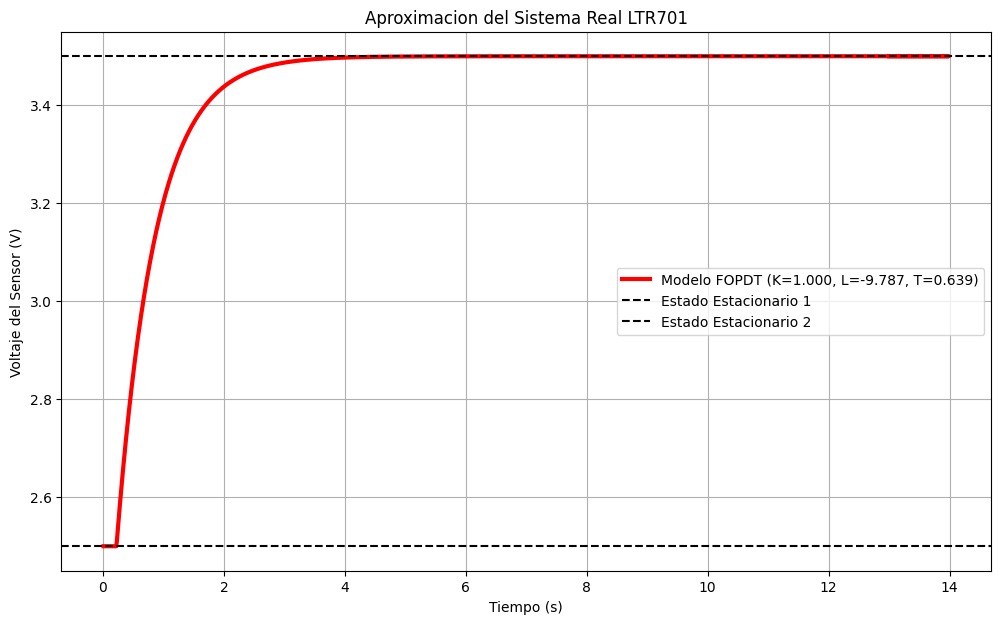

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

nombre_archivo = 'datos_curva_PWM.txt'

y_ss1 = 2.5     # Voltaje de estado estacionario inicia.
y_ss2 = 3.5     # Voltaje de estado estacionario final.
delta_u = 1.0    # Cambio en la entrada.
t_0 = 10.0       # Nota: Convertir el valor de ms a segundos.

# --- Ventana del filtro  (Puedes ajustar este valor si es necesario, 5 o 7 es un buen inicio) ---
window_size = 5

try:
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
    data['t_seg'] = data['Tiempo_ms'] / 1000.0
    data['y_voltaje_ruido'] = data['Valor_ADC'] * (5.0 / 1023.0)

    data['y_voltaje_filtrado'] = data['y_voltaje_ruido'].rolling(window=window_size, center=True).mean()
    
    data = data.dropna()
    
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['y_voltaje_ruido'].to_numpy()       # Voltaje original
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() # Voltaje filtrado
    
    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    t_derivada = t_seg[:-1] # Todos los tiempos excepto el último
    m = np.max(derivada)            # (m) Valor de la derivada máxima
    idx_max = np.argmax(derivada)   # Índice (posición) donde ocurre el máximo
    
    t_inflexion = t_derivada[idx_max] # Tiempo en el que ocurre m
    y_inflexion = y_voltaje_filtrado[idx_max]
    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    L = t_L - t_0
    T = t_T - t_L
    K = (y_ss2 - y_ss1) / delta_u

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K:.3f}")
    print(f"  L = {L:.3f} s")
    print(f"  T = {T:.3f} s")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")

# --- Definir e imprimir la Función de Transferencia (FT) ---
print("\n" + "="*40)
print("Función de Transferencia del Modelo:")
print(f"           {K:.3f} * e^({L:.3f}s)")
print(f"  G(s) = {'-' * (len(str(T)) + 6)}")
print(f"              {T:.3f}s + 1")
print("="*40 + "\n")


try:
    # Cargar datos del Arduino (Tiempo en ms, Valor ADC)
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
    # Convertir a segundos y voltaje
    t_exp = data['Tiempo_ms'] / 1000.0
    y_exp = data['Valor_ADC'] * (5.0 / 1023.0) # Convertir ADC a Voltaje
    

    t_0 = t_exp[t_exp > t_0].iloc[0] # Encuentra el tiempo del escalón (ej. 50s)

    # --- Crear la respuesta del modelo FOPDT ---
    t_sim = t_exp.copy()
    y_sim = np.zeros_like(t_sim)

    for i, t in enumerate(t_sim):
        if t < (t_0 + L):
            y_sim[i] = y_ss1
        else:
            # Ecuación de respuesta al escalón de un FOPDT
            # y = y_inicial + (Ganancia_Total) * (1 - e^(-(t - t_escalon - L) / T))
            y_sim[i] = y_ss1 + (K * delta_u) * (1 - np.exp(-(t - t_0 - L) / T))
            
            # Limitar la respuesta al valor final por si el modelo sobrepasa
            if y_sim[i] > y_ss2:
                y_sim[i] = y_ss2

    # --- Graficar la comparación ---
    plt.figure(figsize=(12, 7))
    plt.plot(t_sim, y_sim, 'r-', linewidth=3, label=f'Modelo FOPDT (K={K:.3f}, L={L:.3f}, T={T:.3f})')
    plt.axhline(y=y_ss1, color='k', linestyle='--', label='Estado Estacionario 1')
    plt.axhline(y=y_ss2, color='k', linestyle='--', label='Estado Estacionario 2')
    
    plt.title('Aproximacion del Sistema Real LTR701')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje del Sensor (V)')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {nombre_archivo}")
    print("Por favor, guarde sus datos del Arduino con ese nombre en la misma carpeta.")


--- PARÁMETROS FOPDT OBTENIDOS ---
  K = 1.000
  L = -2.576 s
  T = 0.465 s

Función de Transferencia del Modelo:
           1.000 * e^(-2.576s)
  G(s) = -------------------------
              0.465s + 1



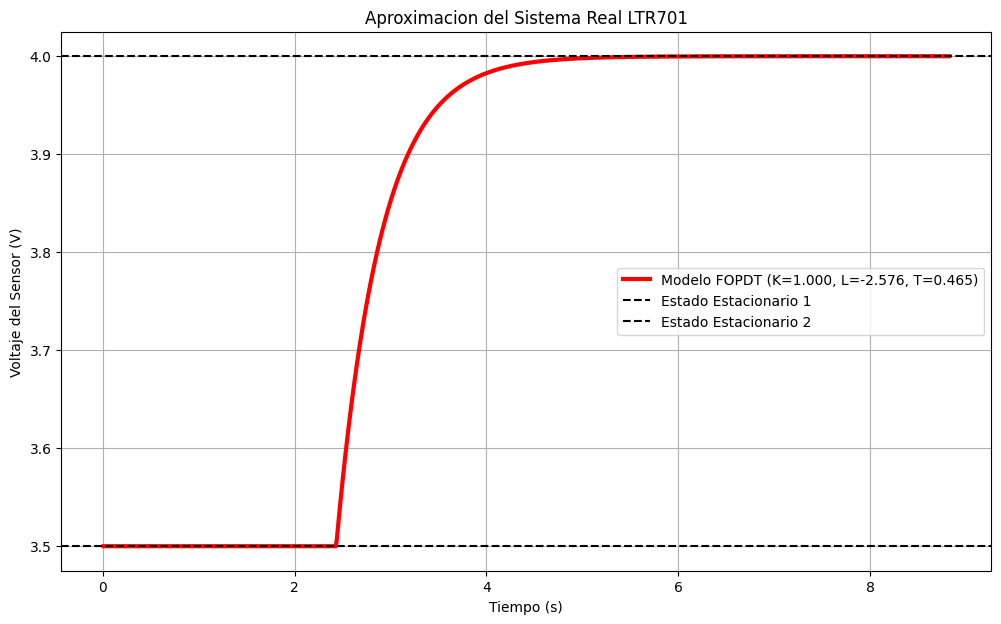

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

nombre_archivo = 'datos_curva_PWM40.txt'

y_ss1 = 3.5     # Voltaje de estado estacionario inicia.
y_ss2 = 4.0     # Voltaje de estado estacionario final.
delta_u = 0.5    # Cambio en la entrada.
t_0 = 5.0       # Nota: Convertir el valor de ms a segundos.

# --- Ventana del filtro  (Puedes ajustar este valor si es necesario, 5 o 7 es un buen inicio) ---
window_size = 5

try:
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
    data['t_seg'] = data['Tiempo_ms'] / 1000.0
    data['y_voltaje_ruido'] = data['Valor_ADC'] * (5.0 / 1023.0)

    data['y_voltaje_filtrado'] = data['y_voltaje_ruido'].rolling(window=window_size, center=True).mean()
    
    data = data.dropna()
    
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['y_voltaje_ruido'].to_numpy()       # Voltaje original
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() # Voltaje filtrado
    
    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    t_derivada = t_seg[:-1] # Todos los tiempos excepto el último
    m = np.max(derivada)            # (m) Valor de la derivada máxima
    idx_max = np.argmax(derivada)   # Índice (posición) donde ocurre el máximo
    
    t_inflexion = t_derivada[idx_max] # Tiempo en el que ocurre m
    y_inflexion = y_voltaje_filtrado[idx_max]
    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    L = t_L - t_0
    T = t_T - t_L
    K = (y_ss2 - y_ss1) / delta_u

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K:.3f}")
    print(f"  L = {L:.3f} s")
    print(f"  T = {T:.3f} s")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")


# --- Definir e imprimir la Función de Transferencia (FT) ---
print("\n" + "="*40)
print("Función de Transferencia del Modelo:")
print(f"           {K:.3f} * e^({L:.3f}s)")
print(f"  G(s) = {'-' * (len(str(T)) + 6)}")
print(f"              {T:.3f}s + 1")
print("="*40 + "\n")


try:
    # Cargar datos del Arduino (Tiempo en ms, Valor ADC)
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
    # Convertir a segundos y voltaje
    t_exp = data['Tiempo_ms'] / 1000.0
    y_exp = data['Valor_ADC'] * (5.0 / 1023.0) # Convertir ADC a Voltaje
    

    t_0 = t_exp[t_exp > t_0].iloc[0] # Encuentra el tiempo del escalón (ej. 50s)

    # --- Crear la respuesta del modelo FOPDT ---
    t_sim = t_exp.copy()
    y_sim = np.zeros_like(t_sim)

    for i, t in enumerate(t_sim):
        if t < (t_0 + L):
            y_sim[i] = y_ss1
        else:
            # Ecuación de respuesta al escalón de un FOPDT
            # y = y_inicial + (Ganancia_Total) * (1 - e^(-(t - t_escalon - L) / T))
            y_sim[i] = y_ss1 + (K * delta_u) * (1 - np.exp(-(t - t_0 - L) / T))
            
            # Limitar la respuesta al valor final por si el modelo sobrepasa
            if y_sim[i] > y_ss2:
                y_sim[i] = y_ss2

    # --- Graficar la comparación ---
    plt.figure(figsize=(12, 7))
    plt.plot(t_sim, y_sim, 'r-', linewidth=3, label=f'Modelo FOPDT (K={K:.3f}, L={L:.3f}, T={T:.3f})')
    plt.axhline(y=y_ss1, color='k', linestyle='--', label='Estado Estacionario 1')
    plt.axhline(y=y_ss2, color='k', linestyle='--', label='Estado Estacionario 2')
    
    plt.title('Aproximacion del Sistema Real LTR701')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje del Sensor (V)')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {nombre_archivo}")
    print("Por favor, guarde sus datos del Arduino con ese nombre en la misma carpeta.")

### ¿Se parece la respuesta real (gráfica del plotter) a su simulación sintonizada de la Celda 11?

Si, aunque aún persisten diferencias, es decir no son idénticas pues la línea generada por Python es la curva ideal, mientras que la línea graficada con los datos obtenidos en la implementación a pesar de estar acondicionada no se asemeja en su totalidad.

### ¿Qué diferencias observa y por qué cree que existen?

Las diferencias entre los resultados obtenidos por el modelo calculado por Python y la implementación se encuentran principalmente en las características de cada "ejecución", un ejemplo es la saturación del actuador. Mientras que en la simulación el controlador es capaz de usar cualquier voltaje para corregir el voltaje, en el Arduino esto se ve limitado por la salida máxima de 5 V, es decir, si el PID calcula que se necesitan 7 V para subir la temperatura, el Arduino solo podrá entregar 5 V.

Otra diferencia radica en las señales, pues mientras en la simulación las señales son limpias en la realidad hay ruido, lo que repercute directamente en el cálculo de la constante Kp provocando que el PWM varíe en mayor medida que en la simulación.

Otro aspecto que detectamos fue que en la simulación la variable de la temperatura se ha considerado lineal, es decir, toma el mismo tiempo aumentarla que disminuirla, mientras que en la realidad esto no es así pues el enfriamiento toma más tiempo.

Finalmente también se toma en cuenta la velocidad con la que se hacen los cálculos, en la simulación se llevan a cabo instantáneamente lo que representa un resolución alta, a diferencia de la realidad donde el Arduino ejecuta el código cada 100 ms aproximadamente lo que conlleva a pequeños retrasos en la toma de decisiones y ejecución de estas.